# 로지스틱 회귀분석
- 출력변수를 직접 예측하는 것이 아니라, 두 개의 카테고리를 가지는 binary 형태의 출력 변수
    > ('성공', '실패' 또는 '예','아니오')를 예측할 때 사용
<br>

- 로지스틱 회귀에서는 k개의 입력 변수를 사용하여 성공 실패를 예측하기 위해 성공 확률 p(X)를 모델링 함.
- 방정식의 왼쪽 범위는 [0,1]이지만, 오른쪽 범위는 [-무한, +무한]이므로 다른 형태로 모델링 해야함.

### 로지스틱 함수
- 왼쪽 항에 자연 로그를 취해줌으로써 ln(p(X))는 [-무한, +무한]이 됨.
    > 이를 만족하기 위해서는 p(X)가 [0, +무한]의 범위여야 함.
<br>

- 하지만 확률 p(X)의 maximum 값은 1이므로 ln(p(X))가 +무한의 값을 가질 수 없음

### 로지스틱 회귀계수 추정
- 단순(다중)선형회귀의 최소제곱법을 사용하는 것이 아닌 최대우도법 사용
    > 최대우도법(Maximum Likelihood)
- 베르누이 확률분포(0 또는 1의 값을 가지는 확률 변수의 확률 분포)를 이용하여 추정.

# 로지스틱 회귀분석 실습 - Personal Loan

In [4]:
import os 
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import statsmodels.api as sm
import matplotlib.pyplot as plt
import itertools
import time

In [33]:
ploan = pd.read_csv('./data/Personal_loan.csv')
ploan.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [34]:
# 의미 없는 변수 제거, ID, zip code 제외
ploan_processed = ploan.dropna().drop(['ID','ZIP Code'], axis=1, inplace=False)

In [35]:
ploan_processed.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,25,1,49,4,1.6,1,0,0,1,0,0,0
1,45,19,34,3,1.5,1,0,0,1,0,0,0
2,39,15,11,1,1.0,1,0,0,0,0,0,0
3,35,9,100,1,2.7,2,0,0,0,0,0,0
4,35,8,45,4,1.0,2,0,0,0,0,0,1


In [36]:
# 상수항 추가
ploan_processed = sm.add_constant(ploan_processed, has_constant='add')
ploan_processed.head()

,const,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1.0,25,1,49,4,1.6,1,0,0,1,0,0,0
1,1.0,45,19,34,3,1.5,1,0,0,1,0,0,0
2,1.0,39,15,11,1,1.0,1,0,0,0,0,0,0
3,1.0,35,9,100,1,2.7,2,0,0,0,0,0,0
4,1.0,35,8,45,4,1.0,2,0,0,0,0,0,1


### 설명변수(X), 타겟변수(Y) 분리 및 학습데이텉와 평가데이터

In [37]:
# 대출 여부 : 1 or 0
feature_columns = ploan_processed.columns.difference(['Personal Loan'])
x = ploan_processed[feature_columns]
y = ploan_processed['Personal Loan']

In [38]:
train_x, test_x, train_y, test_y = train_test_split(x, y, stratify=y, train_size=0.7, test_size=0.3, random_state=42)
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(3500, 12) (1500, 12) (3500,) (1500,)


### 로지스틱 회귀모형 모델링 y=f(x)

In [39]:
# 로지스틱 모형 적합
model = sm.Logit(train_y, train_x) # 회귀적합은 Logic이 아닌 OLS
result = model.fit(method='newton') # newton method는 LR 적합을 시킬 때 Optimizer 기법 적용 시켜주는 것

Optimization terminated successfully.
         Current function value: 0.130868
         Iterations 9


In [40]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Personal Loan   No. Observations:                 3500
Model:                          Logit   Df Residuals:                     3488
Method:                           MLE   Df Model:                           11
Date:                Mon, 15 Mar 2021   Pseudo R-squ.:                  0.5861
Time:                        17:31:30   Log-Likelihood:                -458.04
converged:                       True   LL-Null:                       -1106.7
Covariance Type:            nonrobust   LLR p-value:                1.666e-271
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Age                   -0.0511      0.072     -0.712      0.477      -0.192       0.090
CCAvg                  0.1332      0.046      2.872      0.004       0.042       0.224
CD Account             3.9878      0.402      9.920      0.000       3.200       4.776
CreditCard            -1.1483      0.252     -4.549      0.000      -1.643      -0.654
Education              1.6770      0.136     12.324      0.000       1.410       1.944
Experience             0.0532      0.071      0.746      0.456      -0.087       0.193
Family                 0.7001      0.088      7.925      0.000       0.527       0.873
Income                 0.0525      0.003     17.319      0.000       0.047       0.058
Mortgage               0.0007      0.001      1.039      0.299      -0.001       0.002
Online                -0.6926      0.187     -3.701      0.000      -1.059      -0.326
Securities Account    -1.1086      0.359     -3.089      0.002      -1.812      -0.405
const                -11.7709      1.921     -6.127      0.000     -15.536      -8.006
======================================================================================
"""

- 각각 변수를 보았을 때 경력이나 모기지의 p-value가 높음. 지워야함.

In [41]:
result.params

Age                   -0.051059
CCAvg                  0.133165
CD Account             3.987819
CreditCard            -1.148258
Education              1.676976
Experience             0.053162
Family                 0.700055
Income                 0.052507
Mortgage               0.000691
Online                -0.692613
Securities Account    -1.108634
const                -11.770943
dtype: float64

In [42]:
# 회귀계수 출력
np.exp(result.params)

Age                    0.950223
CCAvg                  1.142438
CD Account            53.937148
CreditCard             0.317189
Education              5.349357
Experience             1.054600
Family                 2.013863
Income                 1.053910
Mortgage               1.000692
Online                 0.500267
Securities Account     0.330009
const                  0.000008
dtype: float64

- 나이가 1살 많을 수록 대출 확률이 0.95배 증가
- 수입이 1단위 높을 수록 대출 확률이 1.05배 증가
- 가족 구성원 수가 1 많을 수록 대출 확률 2.01배 증가
- 경력이 1단위 높을 수록 대출 확률 1.05 증가
    > Experience와 Mortgage는 제외할 필요성 있어보임.

In [43]:
# y_hat 예측
pred_y = result.predict(test_x)
pred_y.head()
# 0.5 이상이면 1로 판단함. 이를 판단해줄 함수 정립

4433    0.000583
274     0.001308
2439    0.000924
1519    0.004975
943     0.076166
dtype: float64

In [44]:
def cut_off(y, threshold):
    Y = y.copy() # copy함수를 사용하여 이전의 y값이 변하지 않게 함.
    Y[Y>threshold] = 1
    Y[Y<=threshold] = 0
    return(Y.astype(int))

pred_Y = cut_off(pred_y, 0.5)
pred_Y

4433    0
274     0
2439    0
1519    0
943     0
       ..
1284    0
1893    0
1649    0
2306    0
3384    0
Length: 1500, dtype: int64

In [45]:
# confusion matrix
cfmat = confusion_matrix(test_y, pred_Y)
print(cfmat)

[[1334   22]
 [  52   92]]


In [46]:
# confusion matrix accuracy 계산하기
# 행렬의 0,0 + 1,1 나누기 전체
(cfmat[0,0] + cfmat[1,1]) / len(pred_Y)

0.9506666666666667

In [47]:
# accuracy를 구하는 함수
def acc(cfmt):
    acc = (cfmat[0,0] + cfmat[1,1]) / len(pred_Y)
    return(acc)

In [48]:
acc(cfmat)

0.9506666666666667

### 임계값(cut-off)에 따른 성능지표 비교

In [49]:
threshold = np.arange(0,1,0.1)
table = pd.DataFrame(columns=['ACC'])
for i in threshold:
    pred_Y = cut_off(pred_y, i)
    cfmat = confusion_matrix(test_y, pred_Y)
    table.loc[i] = acc(cfmat)
table.index.name = 'threshold'
table.columns.name = 'performance'
table

performance,ACC
threshold,
0.0,0.096000
0.1,0.896000
0.2,0.932000
0.3,0.945333
0.4,0.950000
0.5,0.950667
0.6,0.953333
0.7,0.950667
0.8,0.942667


AUC: 0.9639257620452311


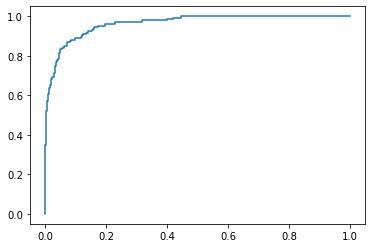

In [50]:
# sklearn ROC 패키지 제공
fpr ,tpr, thresholds = metrics.roc_curve(test_y, pred_y, pos_label=1)

# Print ROC curve
plt.plot(fpr, tpr)

# Print AUC
auc = np.trapz(tpr,fpr)
print('AUC:', auc)

In [51]:
# Experience, Mortgage 변수 제거
feature_columns = list(ploan_processed.columns.difference(['Personal Loan', 'Experience', 'Mortgage']))
X = ploan_processed[feature_columns]
y = ploan_processed['Personal Loan'] # 대출여부 : 1 or 0

In [52]:
train_x2, test_x2, train_y, test_y = train_test_split(X, y, stratify=y, train_size=0.7, test_size=0.3, random_state=42)

In [53]:
# 로지스틱 모델 적합
model = sm.Logit(train_y, train_x2)
result2 = model.fit(method='newton')

Optimization terminated successfully.
         Current function value: 0.131098
         Iterations 9


In [54]:
#이전 모델과 비교
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Personal Loan   No. Observations:                 3500
Model:                          Logit   Df Residuals:                     3488
Method:                           MLE   Df Model:                           11
Date:                Mon, 15 Mar 2021   Pseudo R-squ.:                  0.5861
Time:                        17:37:10   Log-Likelihood:                -458.04
converged:                       True   LL-Null:                       -1106.7
Covariance Type:            nonrobust   LLR p-value:                1.666e-271
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Age                   -0.0511      0.072     -0.712      0.477      -0.192       0.090
CCAvg                  0.1332      0.046      2.872      0.004       0.042       0.224
CD Account             3.9878      0.402      9.920      0.000       3.200       4.776
CreditCard            -1.1483      0.252     -4.549      0.000      -1.643      -0.654
Education              1.6770      0.136     12.324      0.000       1.410       1.944
Experience             0.0532      0.071      0.746      0.456      -0.087       0.193
Family                 0.7001      0.088      7.925      0.000       0.527       0.873
Income                 0.0525      0.003     17.319      0.000       0.047       0.058
Mortgage               0.0007      0.001      1.039      0.299      -0.001       0.002
Online                -0.6926      0.187     -3.701      0.000      -1.059      -0.326
Securities Account    -1.1086      0.359     -3.089      0.002      -1.812      -0.405
const                -11.7709      1.921     -6.127      0.000     -15.536      -8.006
======================================================================================
"""

In [55]:
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Personal Loan   No. Observations:                 3500
Model:                          Logit   Df Residuals:                     3490
Method:                           MLE   Df Model:                            9
Date:                Mon, 15 Mar 2021   Pseudo R-squ.:                  0.5854
Time:                        17:37:14   Log-Likelihood:                -458.84
converged:                       True   LL-Null:                       -1106.7
Covariance Type:            nonrobust   LLR p-value:                2.569e-273
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Age                    0.0023      0.008      0.296      0.767      -0.013       0.017
CCAvg                  0.1280      0.046      2.774      0.006       0.038       0.218
CD Account             4.0025      0.401      9.983      0.000       3.217       4.788
CreditCard            -1.1504      0.252     -4.569      0.000      -1.644      -0.657
Education              1.6499      0.133     12.376      0.000       1.389       1.911
Family                 0.7021      0.088      7.942      0.000       0.529       0.875
Income                 0.0530      0.003     17.559      0.000       0.047       0.059
Online                -0.6932      0.187     -3.707      0.000      -1.060      -0.327
Securities Account    -1.1121      0.358     -3.106      0.002      -1.814      -0.410
const                -13.0585      0.760    -17.176      0.000     -14.549     -11.568
======================================================================================
"""

- Age의 p-value가 급상승

In [56]:
# 예측
pred_y = result2. predict(test_x2)

In [58]:
#threshold 0.5
pred_y2 = cut_off(pred_y, 0.5)

In [59]:
# accuracy 계산
cfmat = confusion_matrix(test_y, pred_y2)
print(acc(cfmat))

0.9526666666666667


In [64]:
threshold = np.arange(0,1,0.1)
pred_y = result2.predict(test_x2)
table = pd.DataFrame(columns=['ACC'])
for i in threshold:
    pred_y2 = cut_off(pred_y, i)
    cfmat = confusion_matrix(test_y, pred_y2)
    table.loc[i] = acc(cfmat)
table.index.name = 'threshold'
table.columns.name = 'performance'
table

performance,ACC
threshold,
0.0,0.096000
0.1,0.896000
0.2,0.934667
0.3,0.945333
0.4,0.950667
0.5,0.952667
0.6,0.952000
0.7,0.952000
0.8,0.942667


AUC: 0.9642791297935103


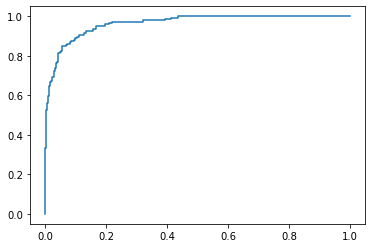

In [66]:
# sklearn ROC 패키지 제공
fpr ,tpr, thresholds = metrics.roc_curve(test_y, pred_y, pos_label=1)

# Print ROC curve
plt.plot(fpr, tpr)

# Print AUC
auc = np.trapz(tpr,fpr)
print('AUC:', auc)

In [68]:
# Age 변수 제거
feature_columns = list(ploan_processed.columns.difference(['Personal Loan', 'Experience', 'Mortgage', 'Age']))
X = ploan_processed[feature_columns]
y = ploan_processed['Personal Loan'] # 대출여부 : 1 or 0

In [69]:
train_x3, test_x3, train_y, test_y = train_test_split(X, y, stratify=y, train_size=0.7, test_size=0.3, random_state=42)

In [70]:
# 로지스틱 모델 적합
model = sm.Logit(train_y, train_x3)
result3 = model.fit(method='newton')

Optimization terminated successfully.
         Current function value: 0.131110
         Iterations 9


In [71]:
#이전 모델과 비교
result3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Personal Loan   No. Observations:                 3500
Model:                          Logit   Df Residuals:                     3491
Method:                           MLE   Df Model:                            8
Date:                Mon, 15 Mar 2021   Pseudo R-squ.:                  0.5854
Time:                        17:43:44   Log-Likelihood:                -458.89
converged:                       True   LL-Null:                       -1106.7
Covariance Type:            nonrobust   LLR p-value:                2.042e-274
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
CCAvg                  0.1264      0.046      2.757      0.006       0.037       0.216
CD Account             4.0044      0.401      9.988      0.000       3.219       4.790
CreditCard            -1.1493      0.252     -4.564      0.000      -1.643      -0.656
Education              1.6483      0.133     12.383      0.000       1.387       1.909
Family                 0.7011      0.088      7.932      0.000       0.528       0.874
Income                 0.0529      0.003     17.566      0.000       0.047       0.059
Online                -0.6902      0.187     -3.697      0.000      -1.056      -0.324
Securities Account    -1.1104      0.358     -3.104      0.002      -1.812      -0.409
const                -12.9449      0.653    -19.811      0.000     -14.226     -11.664
======================================================================================
"""

In [73]:
# 예측
pred_y = result3. predict(test_x3)

In [74]:
#threshold 0.5
pred_y3 = cut_off(pred_y, 0.5)

In [75]:
# accuracy 계산
cfmat = confusion_matrix(test_y, pred_y3)
print(acc(cfmat))

0.9526666666666667


In [76]:
threshold = np.arange(0,1,0.1)
pred_y = result3.predict(test_x3)
table = pd.DataFrame(columns=['ACC'])
for i in threshold:
    pred_y3 = cut_off(pred_y, i)
    cfmat = confusion_matrix(test_y, pred_y3)
    table.loc[i] = acc(cfmat)
table.index.name = 'threshold'
table.columns.name = 'performance'
table

performance,ACC
threshold,
0.0,0.096000
0.1,0.896000
0.2,0.932667
0.3,0.944000
0.4,0.950667
0.5,0.952667
0.6,0.952000
0.7,0.952000
0.8,0.943333


AUC: 0.9641459767289412


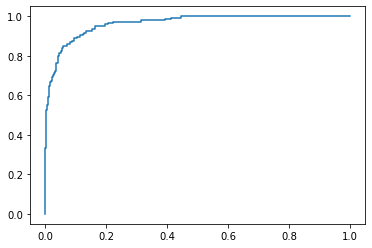

In [77]:
# sklearn ROC 패키지 제공
fpr ,tpr, thresholds = metrics.roc_curve(test_y, pred_y, pos_label=1)

# Print ROC curve
plt.plot(fpr, tpr)

# Print AUC
auc = np.trapz(tpr,fpr)
print('AUC:', auc)

### 변수 선택법

In [78]:
feature_columns = list(ploan_processed.columns.difference(["Personal Loan"]))
X = ploan_processed[feature_columns]
y = ploan_processed['Personal Loan']

In [79]:
train_x, test_x, train_y, test_y = train_test_split(X, y, stratify=y, train_size=0.7, test_size=0.3, random_state=42)

In [85]:
 def processSubset(X, y, feature_set):
    model = sm.OLS(y, X[list(feature_set)]) # Modeling
    regr = model.fit() # 모델 학습
    AIC = regr.aic # 모델의 AIC
    return {"model" : regr, "AIC" : AIC}

'''
전진선택법
'''

def forward(X, y, predictors):
    # 데이터 변수들이 미리 정의된 predictors에 있는지 없는지 확인 및 분류
    remaining_predictors = [p for p in X.columns.difference(['const']) if p not in predictors]
    tic = time.time()
    results = []
    for p in remaining_predictors:
        results.append(processSubset(X=X, y=y, feature_set=predictors+[p]+['const']))
    # 데이터 프레임으로 변환
    models = pd.DataFrame(results)
    
    # AIC가 가장 낮은 것을 선택
    best_model = models.loc[models['AIC'].argmin()] # index
    toc = time.time() # 종료 시간
    print('Processed', models.shape[0], 'models on', len(predictors)+1, 'predictors in', (toc - tic))
    print('Selected predictors:', best_model['model'].model.exog_names, 'AIC:', best_model[0])
    return best_model

def forward_model(X,y):
    Fmodels = pd.DataFrame(columns=['AIC', 'model'])
    tic = time.time()
    # 미리 정의된 데이터 변수
    predictors = []
    # 변수 1~10개 : 0~9 -> 1~10
    for i in range(1, len(X.columns.difference(['const'])) + 1):
        Forward_result = forward(X=X, y=y, predictors=predictors)
        if i > 1:
            if Forward_result['AIC'] > Fmodels_before:
                break
        Fmodels.loc[i] = Forward_result
        predictors = Fmodels.loc[i]['model'].model.exog_names
        Fmodels_before = Fmodels.loc[i]['AIC']
        predictors = [k for k in predictors if k != 'const']
    toc = time.time()
    print('Total elapsed time:', (toc - tic), 'seconds.')
    
    return(Fmodels['model'][len(Fmodels['model'])])

'''
후진소거법
'''
def backward(X, y, predictors):
    tic = time.time() # 시작시간
    results = [] # 결과 저장공간
    for combo in itertools.combinations(predictors, len(predictors) - 1): # 각 변수 조합을 고려한 경우의 수
        results.append(processSubset(X=X, y=y, feature_set = list(combo)+['const']))
    models=pd.DataFrame(results) # 데이터 프레임으로 변환
    # 가장 낮은 AIC를 가지는 모델 선택 및 저장
    best_model = models.loc[models['AIC'].argmin()] # index # AIC가 가장 낮은 모델
    toc = time.time() # 종료 시간
    print('Processed', models.shape[0], 'models on', len(predictors) - 1, 'predictors in', (toc - tic))
    print('Selected predictors:', best_model['model'].model.exog_names, 'AIC:' ,best_model[0])
    return best_model

def backward_model(X, y):
    Bmodels = pd.DataFrame(columns=['AIC', 'model'], index = range(1, len(X.columns)))
    tic = time.time()
    predictors = X.columns.difference(['const'])
    Bmodel_before = processSubset(X, y, predictors)['AIC']
    while (len(predictors) > 1):
        Backward_result = backward(X=train_x, y=train_y, predictors = predictors)
        if Backward_result['AIC'] > Bmodel_before:
            break
        Bmodels.loc[len(predictors)-1] = Backward_result
        predictors = Bmodels.loc[len(predictors)-1]['model'].model.exog_names
        Bmodel_before = Backward_result['AIC']
        predictors = [k for k in predictors if k != 'const']
        
    toc = time.time()
    print('Total elapsed time:', (toc - tic), 'Seconds.')
    return(Bmodels['model'].dropna().iloc[0])

'''
단계적선택법
'''
def Stepwise_model(X, y):
    Stepmodels = pd.DataFrame(columns=['AIC', 'model'])
    tic = time.time()
    predictors = []
    Smodel_before = processSubset(X, y, predictors + ['const'])['AIC']
    # 변수 1~10개 : 0~9 -> 1~10
    for i in range(1, len(X.columns.difference(['const'])) + 1):
        Forward_result = forward(X=X, y=y, predictors=predictors)
        print('forward')
        Stepmodels.loc[i] = Forward_result
        predictors = Stepmodels.loc[i]['model'].model.exog_names
        predictors = [k for k in predictors if k != 'const']
        Backward_result = backward(X=X, y=y, predictors = predictors)
        if Backward_result['AIC']<Forward_result['AIC']:
            Stepmodels.loc[i] = Backward_result
            predictors = Stepmodels.loc[i]['model'].model.exog_names
            Smodel_before = Stepmodels.loc[i]['AIC']
            predictors = [k for k in predictors if k != 'const']
            print('backward')
        if Stepmodels.loc[i]['AIC']>Smodel_before:
            break
        else:
            Smodel_before = Stepmodels.loc[i]['AIC']
    toc = time.time()
    print('Total elapsed time:', (toc-tic), 'seconds.')
    return(Stepmodels['model'][len(Stepmodels['model'])])

In [86]:
Forward_best_model = forward_model(X=train_x, y=train_y)

Processed 11 models on 1 predictors in 0.02805185317993164
Selected predictors: ['Income', 'const'] AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fb990f801f0>
Processed 10 models on 2 predictors in 0.015556097030639648
Selected predictors: ['Income', 'CD Account', 'const'] AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fb990f80a00>
Processed 9 models on 3 predictors in 0.013983964920043945
Selected predictors: ['Income', 'CD Account', 'Education', 'const'] AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fb991619fa0>
Processed 8 models on 4 predictors in 0.01125192642211914
Selected predictors: ['Income', 'CD Account', 'Education', 'Family', 'const'] AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fb9603acf70>
Processed 7 models on 5 predictors in 0.009875059127807617
Selected predictors: ['Income', 'CD Account', 'Education', 'Family', 'CreditCard', 'const']

In [87]:
Backward_best_model = backward_model(X=train_x, y=train_y)

Processed 11 models on 10 predictors in 0.03861689567565918
Selected predictors: ['CCAvg', 'CD Account', 'CreditCard', 'Education', 'Experience', 'Family', 'Income', 'Mortgage', 'Online', 'Securities Account', 'const'] AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fb990f806a0>
Processed 10 models on 9 predictors in 0.01883387565612793
Selected predictors: ['CCAvg', 'CD Account', 'CreditCard', 'Education', 'Family', 'Income', 'Mortgage', 'Online', 'Securities Account', 'const'] AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fb991a7eb80>
Processed 9 models on 8 predictors in 0.013358831405639648
Selected predictors: ['CCAvg', 'CD Account', 'CreditCard', 'Education', 'Family', 'Income', 'Online', 'Securities Account', 'const'] AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fb984896160>
Total elapsed time: 0.08801627159118652 Seconds.


In [89]:
Stepwise_best_model = Stepwise_model(X=train_x, y=train_y)

Processed 11 models on 1 predictors in 0.024749040603637695
Selected predictors: ['Income', 'const'] AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fb990f801f0>
forward
Processed 1 models on 0 predictors in 0.003120899200439453
Selected predictors: ['const'] AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fb9914dd310>
Processed 10 models on 2 predictors in 0.01747608184814453
Selected predictors: ['Income', 'CD Account', 'const'] AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fb990f80370>
forward
Processed 2 models on 1 predictors in 0.004773139953613281
Selected predictors: ['Income', 'const'] AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fb9603ac550>
Processed 9 models on 3 predictors in 0.011451005935668945
Selected predictors: ['Income', 'CD Account', 'Education', 'const'] AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7

In [98]:
# 모델에 의해 예측된/추정된 값 <=> test_y
pred_y_full = result.predict(test_x)
pred_y_forward = Forward_best_model.predict(test_x[Forward_best_model.model.exog_names])
pred_y_backward = Backward_best_model.predict(test_x[Backward_best_model.model.exog_names])
pred_y_stepwise = Stepwise_best_model.predict(test_x[Stepwise_best_model.model.exog_names])

In [99]:
pred_Y_full = cut_off(pred_y_full, 0.5)
pred_Y_forward = cut_off(pred_y_forward, 0.5)
pred_Y_backward = cut_off(pred_y_backward, 0.5)
pred_Y_stepwise = cut_off(pred_y_stepwise, 0.5)

In [100]:
cfmat_full = confusion_matrix(test_y, pred_Y_full)
cfmat_forward = confusion_matrix(test_y, pred_Y_forward)
cfmat_backward = confusion_matrix(test_y, pred_Y_backward)
cfmat_stepwise = confusion_matrix(test_y, pred_Y_stepwise)

In [101]:
print(acc(cfmat_full))
print(acc(cfmat_forward))
print(acc(cfmat_backward))
print(acc(cfmat_stepwise))

0.9333333333333333
0.9333333333333333
0.9333333333333333
0.9333333333333333


- 값이 같게 나와 각 길이 확인

In [103]:
print(len(result.model.exog_names))
print(len(Forward_best_model.model.exog_names))

12
10


AUC: 0.9639257620452311


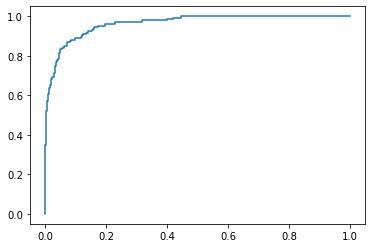

In [104]:
# sklearn ROC 패키지 제공
fpr ,tpr, thresholds = metrics.roc_curve(test_y, pred_y_full, pos_label=1)

# Print ROC curve
plt.plot(fpr, tpr)

# Print AUC
auc = np.trapz(tpr,fpr)
print('AUC:', auc)

AUC: 0.9588403392330384


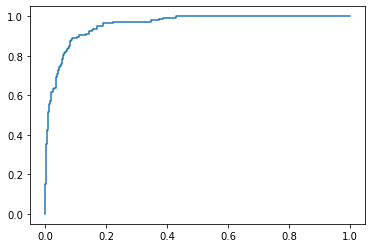

In [106]:
# sklearn ROC 패키지 제공
fpr ,tpr, thresholds = metrics.roc_curve(test_y, pred_y_forward, pos_label=1)

# Print ROC curve
plt.plot(fpr, tpr)

# Print AUC
auc = np.trapz(tpr,fpr)
print('AUC:', auc)

AUC: 0.9588403392330384


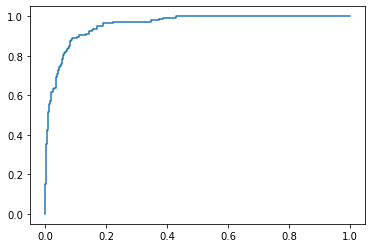

In [107]:
# sklearn ROC 패키지 제공
fpr ,tpr, thresholds = metrics.roc_curve(test_y, pred_y_backward, pos_label=1)

# Print ROC curve
plt.plot(fpr, tpr)

# Print AUC
auc = np.trapz(tpr,fpr)
print('AUC:', auc)

AUC: 0.9588403392330384


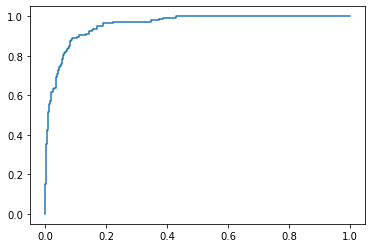

In [108]:

# sklearn ROC 패키지 제공
fpr ,tpr, thresholds = metrics.roc_curve(test_y, pred_y_stepwise, pos_label=1)

# Print ROC curve
plt.plot(fpr, tpr)

# Print AUC
auc = np.trapz(tpr,fpr)
print('AUC:', auc)

- 성능 면에서는 full 모델의 AUC가 가장 높아 적합한 모델이라 볼 수 있다.